<a href="https://colab.research.google.com/github/Nickeniklas/SARIMAX_stockdata_forecasting/blob/main/stockdata_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock data Forecasting

forecasting with SARIMAX

Fetching with yfinance



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# set fetch data parameters
ticker = "ALFA.ST"
start_date = "2010-01-01"
end_date = "2020-01-01"
interval = "1d"
period = "5y"


In [26]:
# fetch data
data = yf.download(ticker, period=period, interval=interval, keepna=True)

[*********************100%***********************]  1 of 1 completed


In [27]:
# set frequency
data = data.asfreq('B')

## Data discovery

In [28]:
data

Price,Close,High,Low,Open,Volume
Ticker,ALFA.ST,ALFA.ST,ALFA.ST,ALFA.ST,ALFA.ST
Date,,,,,
2020-05-27,174.978760,176.344004,169.108214,169.290244,1219301.0
2020-05-28,178.164322,178.528381,174.341642,176.571537,1064600.0
2020-05-29,172.839874,176.617057,171.838704,176.617057,1517919.0
2020-06-01,174.250610,175.206284,171.702153,175.160773,446874.0
2020-06-02,178.573898,180.621764,174.432656,174.432656,1021608.0
...,...,...,...,...,...
2025-05-21,415.799988,423.100006,413.700012,420.000000,926081.0
2025-05-22,408.899994,413.700012,407.600006,413.700012,666112.0


In [31]:
# check for NaN values
data.isna().sum()  # count per column

,,0
Price,Ticker,
Close,ALFA.ST,0
High,ALFA.ST,0
Low,ALFA.ST,0
Open,ALFA.ST,0
Volume,ALFA.ST,0


In [30]:
# fill NaN with previos value
data = data.ffill()

<Axes: xlabel='Date'>

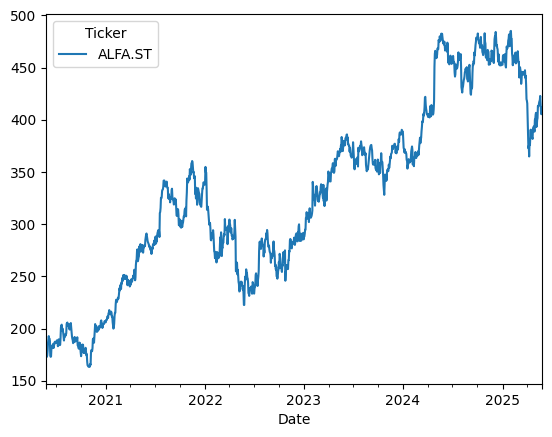

In [32]:
# Basic visualization
data.plot(y="Close", use_index=True)

<Axes: xlabel='Date'>

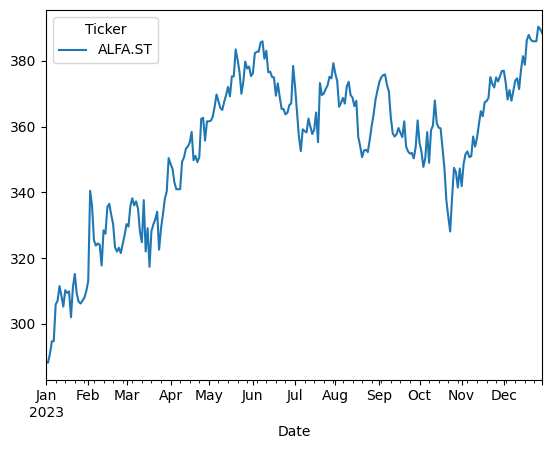

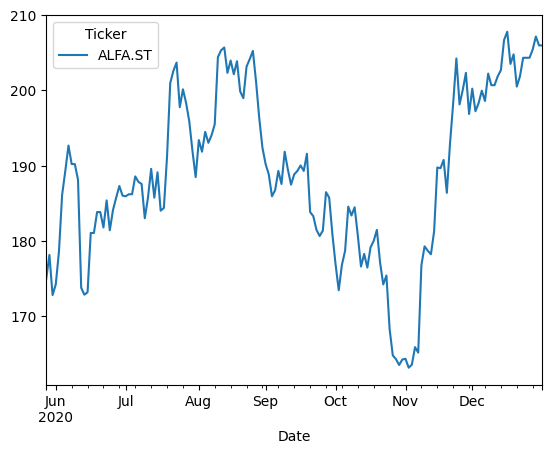

In [75]:
# plot one year
data.loc['2023'].plot(y="Close", use_index=True)
data.loc['2020'].plot(y="Close", use_index=True)

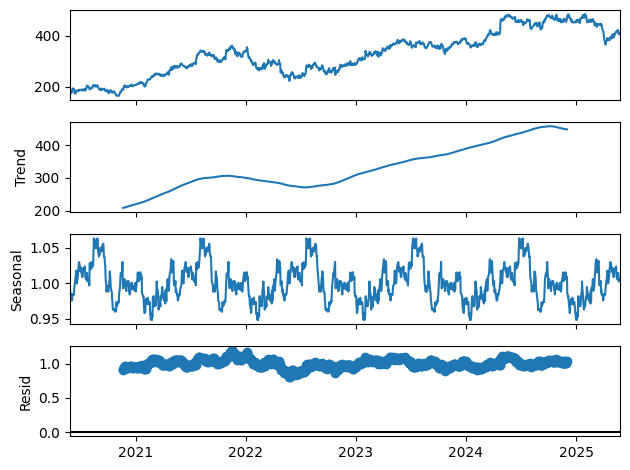

In [43]:
# decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data["Close"], model='multiplicative', period=252) # period = business year
decomposition.plot()
plt.show()

## Remove trend

1 level of differencing

In [46]:
# 1 level of diff
data["Close_diff"] = data["Close"].diff()

<Axes: xlabel='Date'>

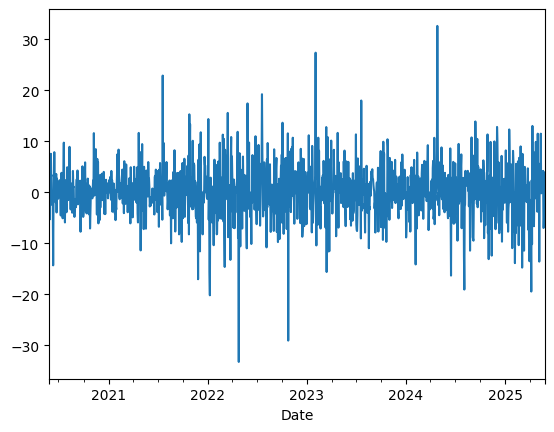

In [47]:
# plot Close_diff
data["Close_diff"].plot()

In [48]:
# ADF to ensure stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(data["Close_diff"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -19.093797
p-value: 0.000000


## ACF & PACF Plot

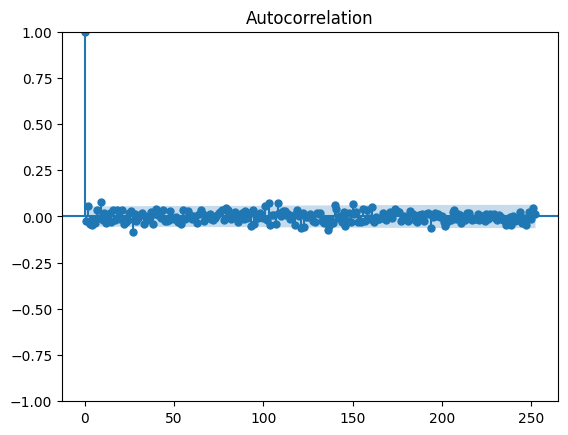

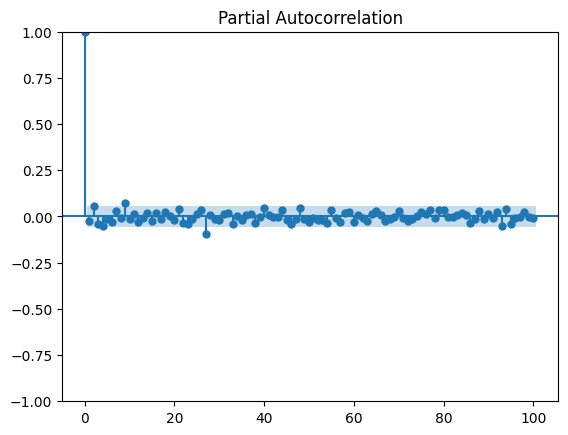

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data["Close_diff"].dropna(), lags=252)
plot_pacf(data["Close_diff"].dropna(), lags=100)
plt.show()

## Split data

Train and Test

In [76]:
train = data['Close'][:'2023']
test = data['Close']['2023':]

## Fit SARIMA model



In [80]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
p = 1
d = 1
q = 0
P = 1
D = 1
Q = 0
s = 21
model = SARIMAX(
    train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s))
model_fit = model.fit()

In [81]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            ALFA.ST   No. Observations:                  938
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 21)   Log Likelihood               -2983.838
Date:                            Tue, 27 May 2025   AIC                           5973.676
Time:                                    18:57:31   BIC                           5988.136
Sample:                                05-27-2020   HQIC                          5979.195
                                     - 12-29-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0528      0.029     -1.799      0.072      -0.110       0.005
ar.S.L21      -0.4548      0.025    -18.001      0.000      -0.504      -0.405
sigma2        39.3204      1.162     33.837      0.000      37.043      41.598
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               379.74
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecast

In [84]:
# Get forecast with confidence intervals
forecast = model_fit.get_forecast(steps=90)

# Extract the forecasted values
forecast_values = forecast.predicted_mean

# Extract the confidence intervals (lower and upper bounds)
forecast_conf_int = forecast.conf_int()

## Visualize forecast

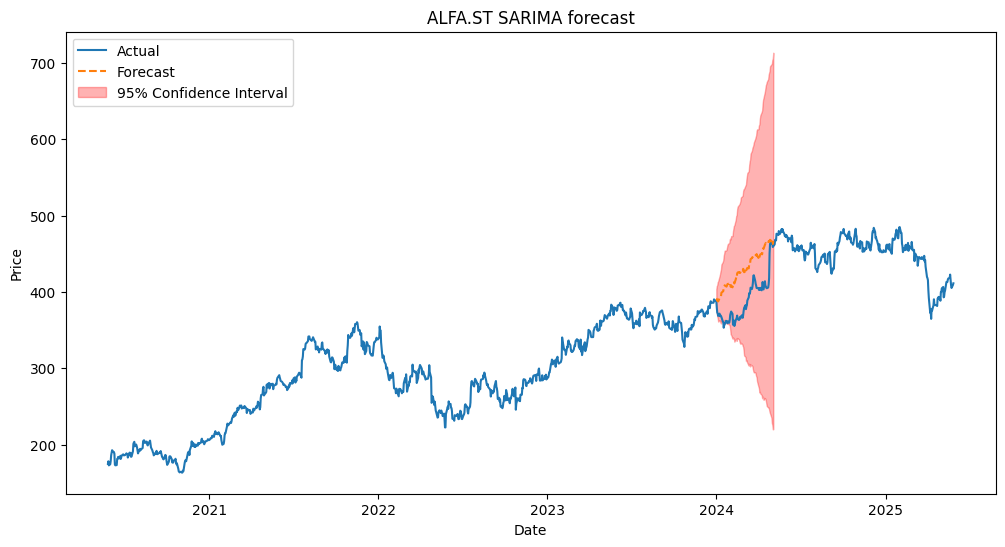

In [85]:
plt.figure(figsize=(12, 6))
plt.title(f"{ticker} SARIMA forecast")
plt.xlabel("Date")
plt.ylabel("Price")

plt.plot(data.index, data["Close"], label="Actual")
plt.plot(forecast_values.index, forecast_values, label="Forecast", linestyle="--")
plt.fill_between(
    forecast_conf_int.index,
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color="red",
    alpha=0.3,
    label="95% Confidence Interval")

plt.legend()
plt.show()